Você foi contratado para criar um sistema que realiza a classificação de imagens de frutas para uma empresa de e-commerce. O objetivo é que, ao enviar uma imagem, o sistema identifique se a fruta é uma maçã, uma banana ou uma laranja. Sabendo que você possui um banco de imagens já categorizado, explique quais tipos de redes neurais você utilizaria para resolver esse problema, como seria o processo de implementação utilizando Python e quais etapas principais precisam ser seguidas para treinar o modelo.
Padrão de Resposta para a Atividade:

- Indicação clara do tipo de rede neural usada e justificativa do porquê de ser a escolha mais adequada;
- Descrição do processo de pré-processamento das imagens;
- Apresentação do modelo de rede neural em Python, com uma breve explicação de cada camada;
- Compilação e treinamento do modelo, mencionando a função de perda e o otimizador usados;
- Processo de avaliação e validação do modelo;
- Conclusão explicando como o modelo resolverá o problema proposto.

## Oficina 2: Sistema de classificação de imagens

### 1. Introdução

O objetivo do projeto é criar um sistema capaz de receber uma imagem de uma fruta e retornar a sua classificação como sendo uma maça, banana ou laranja, para isso é necessário criar um modelo de aprendizado supervisionado capaz de reconhecer caracteríticas das frutas pretendidas por meio de um banco de imagens pré-rotuladas.

### 1.1 Recursos 

### Bibliotecas


- **Seaborn**, biblioteca em python foi utilizada para gerar gráfico de comparação da acurácia ao longo das epochs.
- **Scikit-learn**, para clasular métricas de avaliação.
  - confusion_matrix: Matriz de confusão para análise de desempenho.
  - classification_report: Relatório com precisão, recall e F1-score.
- **Tensor-flow**, para o carregamento e tratamento dos dados utilizados na modelagem e para a criação, treinamento e avaliação de modelo de classificação.
- **Numpy**, para conversão de imagens em array multidimensionais.
- **TensorFlow**, para construção e treinamento de modelos de deep learning.
- **Keras** (tensorflow.keras), API de alto nível para redes neurais (integradas ao TensorFlow).
  - Sequential: Modelo sequencial para empilhar camadas.
  - layers: Camadas pré-definidas (ex: Conv2D, MaxPooling2D, Dense).
  - ImageDataGenerator: Pré-processamento e aumento de dados para imagens.

In [3]:
import pandas as pd
import seaborn as sns
import sklearn as sk 
import numpy as np
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os



2025-02-22 01:22:21.565781: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 01:22:21.784475: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 01:22:21.883276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740187342.030836    3528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740187342.067374    3528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 01:22:22.377095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 2. Compreensão dos Dados

A fonte de dados utilizado foi o dataset público disponível no Kaggle chamado [Fruits 360 Dataset (100x100)](https://www.kaggle.com/datasets/moltean/fruits/data?select=fruits-360_dataset_100x100), que contém divers imagens de frutas categorizados. Esse dataset foi escolhido, dentre outros semelhantes, pela enorme quantidade, qualidade e variedade de imagens, o que é ideal para o treinamento de um modelo de clssificação de imagens em que o algortimo precisa ter a oportunidade de entrar em contato com o máximo de características distintas do mesmo rótulo para conseguir generalizar bem com dados reais.

As imagens estão armazenadas em dois diretórios principais "teste" e "treinamento", em cada um dos diretórios as imagens estão dispostas nos subdiretórios  "Apple", "Banana" e "Orange" 

| Tipo de Imagem | Quantidade |     
|----------------|------------|
| Treinamento    | 10190      |
| Teste          | 3403       |
---
| Fruta   | Treinamento e Teste | Validação  |
|---------|-------------|-------|
| Apple   | 7579        | 2525  |
| Orange  | 1181        | 394   |
| Banana  | 1430        | 484   |



In [4]:
# O caminho para os diretórios de treinamento e teste são armazenados nas seguintes variáveis:
val_path = ("/workspaces/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/treinamento")
train_path = ("/workspaces/Uece-C-Jovem/Ciência de Dados - Avançado/aux/360fruits/teste")

In [6]:
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_images_in_directory(train_path)
test_count = count_images_in_directory(val_path)

print(f"Quantidade de imagem para Treinamento e Teste: {train_count}")
print(f"Quantidade de imagens para Validação: {test_count}")

# Calculate and display metrics for each subdirectory
def calculate_metrics(directory):
    metrics = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            metrics[subdir] = count_images_in_directory(subdir_path)
    return metrics

train_metrics = calculate_metrics(train_path)
test_metrics = calculate_metrics(val_path)

print("Quantidade de imagens para Treinamento por fruta:")
for fruit, count in train_metrics.items():
    print(f"{fruit}: {count} images")

print("Quantidade de imagens para Validação por fruta:")
for fruit, count in test_metrics.items():
    print(f"{fruit}: {count} images")


Quantidade de imagem para Treinamento e Teste: 10190
Quantidade de imagens para Validação: 3403
Quantidade de imagens para Treinamento por fruta:
Apple: 7579 images
Orange: 1181 images
Banana: 1430 images
Quantidade de imagens para Validação por fruta:
Apple: 2525 images
Orange: 394 images
Banana: 484 images


**Mostra das imagens que estão no diretório e sua respectivas classes**

Found 10190 files belonging to 3 classes.


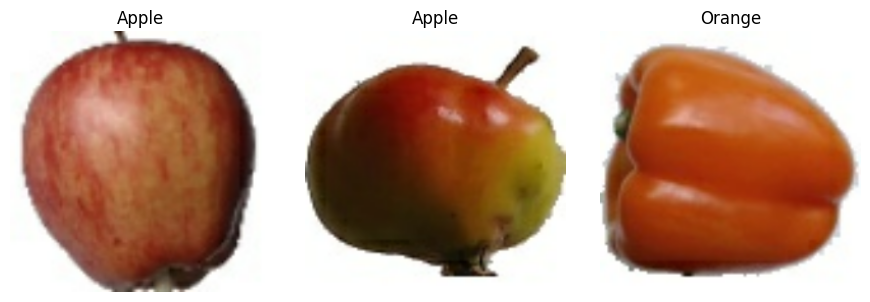

2025-02-22 01:30:59.964313: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, 
)

# Pegar uma amostra de cada classe
for images, labels in train_data.take(1):
   
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    
    # Mostrar apenas as 3 primeiras imagens
    for i in range(3):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].set_title(train_data.class_names[labels[i]])
        axes[i].axis("off")
    
    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


### 3. Preparação de dados

**A dimensão das imagens é definida para 100 de altura e 100 de largura, isso é importante para o modelo de rede neural que será criado posteriormente,
pois o algoritmo espera que todas as imagens tenham o mesmo tamanho.**

In [ ]:
img_widht = 100
img_height = 100


**O dicionário dataset_params define parâmetro que será utilizados no carregamento das imagens no ambiente tf.kera:**

- **labels:** "inferred" significa que as labels serão inferidas dos nomes das pastas
- **label_mode:** "int" indica que as labels serão números inteiros
- **image_size:** Define o tamanho das imagens (largura e altura)
- **color_mode:** "rgb" especifica imagens coloridas com 3 canais
- **batch_size:** Define 32 imagens por lote
- **shuffle:** Embaralha os dados durante o treinamento

**'experimental.AUTOTUNE':** Foi utilizado o resurso 'experimental.AUTOTUNE' que é uma constante do TensorFlow que otimiza automaticamente o pipeline de dados garantindo mais eficiencia e 

In [ ]:

dataset_params = {
    "labels": "inferred",
    "label_mode": "int",
    "image_size": (img_widht, img_height),
    "color_mode": "rgb",
    "batch_size": 32,
    "shuffle": True
}

AUTO = tf.data.experimental.AUTOTUNE

Found 10190 files belonging to 3 classes.
Using 8152 files for training.
Found 3403 files belonging to 3 classes.


**As imagens são carregadas do diretório de treino e de teste usando os parâmetros definidos anteriormente. A fim do acompanhamen durante o treinamento, são reservados dos dados de treinamento 20% para fim de validação.**

- **validation_split=0.2:** Separa 20% dos dados para validação
- **subset="training":** Indica que este é o conjunto de treino
- **seed=123:** Garante reprodutibilidade no embaralhamento

In [ ]:

data_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    **dataset_params,
    validation_split=0.2,
    subset="training",
    seed=123
)
data_val = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    **dataset_params,
    validation_split=0.2,
    subset="validation
)
class_names = data_train.class_names

data_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    **dataset_params,  # Use ** to unpack the dictionary
        # Override shuffle parameter for test data
)

data_train = data_train.prefetch(buffer_size=AUTO)
data_val = data_val.prefetch(buffer_size=AUTO)
data_test = data_test.prefetch(buffer_size=AUTO)

**O modelo escolhido para o alcançar o objetivo do projeto foi a Redes Neurais Convolucionais (CNNs) pois ela explora muito bem a estrutura espacial dos dados de imagem, oferece eficiência computacional e uma robusta capacidade de generalização para novas amostras.**

**O modelo possui as seguintes características:**

- A primeira camada convolucional (Conv2D) com 32 filtros e kernel 3×3, com ReLU, extrai características iniciais das imagens, que possuem tamanho 100×100 e 3 canais (RGB).
- A camada de MaxPooling2D reduz a dimensionalidade e o custo computacional, mantendo características importantes.
- A segunda camada convolucional aumenta a complexidade das características extraídas com 64 filtros, seguida por outra camada de pooling para novo downsampling.
- A função Flatten converte os dados multidimensionais em um vetor unidimensional para a fase densa.
- A camada Dense com 128 neurônios utiliza a ativação ReLU para aprender combinações não lineares das características extraídas.
- A camada final Dense com 3 unidades e softmax gera a probabilidade de cada uma das 3 classes, sendo o softmax ideal para problemas de classificação.

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)), # Modelo
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 10 classes
   
])



/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- **Otimizador Adam: adapta automaticamente a taxa de aprendizado**
- **Loss function 'sparse_categorical_crossentropy': ideal para classificação multiclasse**
- **Métricas de accuracy para avaliar performance**

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

- **O treinamento do modelo é feito usando o dataset de treinamento (data_train), durante 10 épocas, com lotes de 64 amostras.**
- **Durante o treinamento, o desempenho é validado utilizando o conjunto data_test.**
- **O objeto history armazena os valores da perda e da acurácia para cada época, permitindo analisar a evolução do treinamento e a performance do modelo.**

In [ ]:
history = model.fit(
    data_train,  # Imagens de treinamento e rótulos de treinamento incluídos no tf.data.Dataset
    epochs=10,    # Número de épocas
    batch_size=64,  # Tamanho do lote
    validation_data=data_val  # Dados de validação
)

Epoch 1/10


2025-02-21 12:41:01.637196: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39337984 exceeds 10% of free system memory.
2025-02-21 12:41:01.755222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25447680 exceeds 10% of free system memory.
2025-02-21 12:41:01.802905: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39337984 exceeds 10% of free system memory.


  2/255 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.6484 - loss: 233.3835

2025-02-21 12:41:01.860901: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39337984 exceeds 10% of free system memory.
2025-02-21 12:41:01.918016: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25447680 exceeds 10% of free system memory.


255/255 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.8930 - loss: 51.6793 - val_accuracy: 0.9812 - val_loss: 0.0568
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 1.0000 - loss: 1.1804e-04 - val_accuracy: 0.9909 - val_loss: 0.0214
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 1.0000 - loss: 7.5382e-06 - val_accuracy: 0.9915 - val_loss: 0.0212
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 1.0000 - loss: 3.0217e-06 - val_accuracy: 0.9915 - val_loss: 0.0197
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 1.0000 - loss: 1.7774e-06 - val_accuracy: 0.9918 - val_loss: 0.0186
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 1.0000 - loss: 1.1658e-06 - val_accuracy: 0.9921 - val_loss: 0.0179
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 140ms/step - accuracy: 1.0000 - loss: 8.3136e-07 - val_accuracy: 0.9921 - val_loss: 0.0173
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 141ms/step - accuracy: 1.

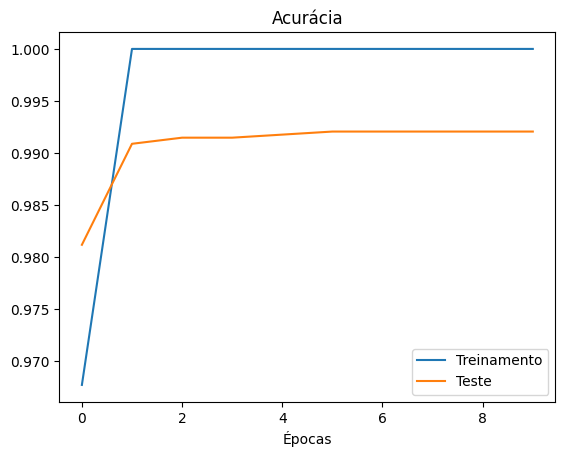

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Teste')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.legend()
plt.show()

In [ ]:
# Predict on the entire test dataset
y_pred = model.predict(data_test)

# Extract true labels from data_test
true_labels = np.concatenate([y for x, y in data_test], axis=0)

# Get the predicted labels
predicted_labels = np.argmax(y_pred, axis=1)

confusion_matrixm = sk.metrics.confusion_matrix(true_labels, predicted_labels)

 25/107 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


Acurácia final no teste: 1.0000
  5/107 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2525
           1       1.00      1.00      1.00       484
           2       0.98      0.95      0.97       394

    accuracy                           0.99      3403
   macro avg       0.99      0.98      0.99      3403
weighted avg       0.99      0.99      0.99      3403



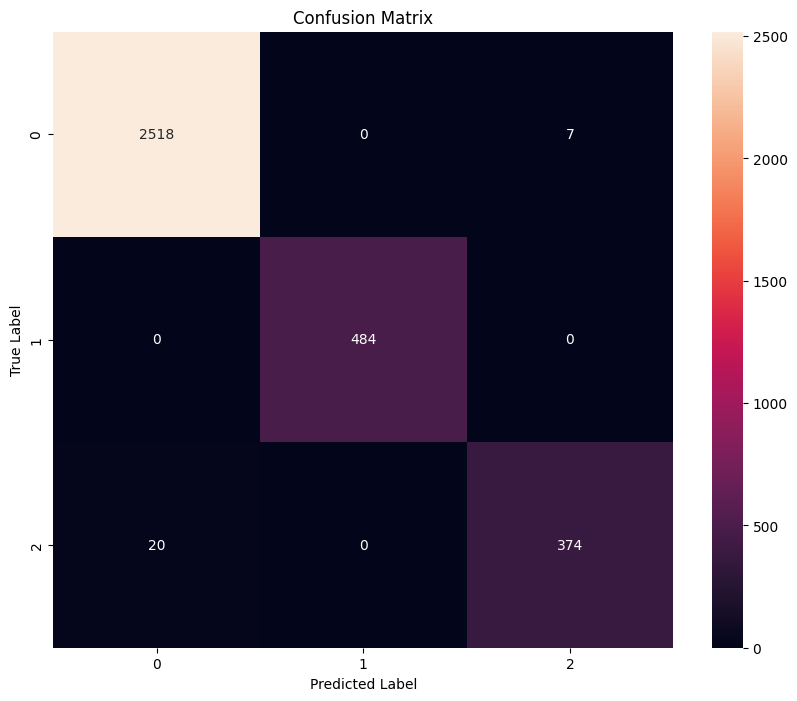

In [ ]:
loss, accuracy = history.history['loss'], history.history['accuracy']
print(f"Acurácia final no teste: {accuracy[-1]:.4f}")

# Get predictions for the test dataset
y_pred = model.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in data_test], axis=0)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()